In [80]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import keras
import optuna

import plotly.express as px
import matplotlib.pyplot as plt

from keras import layers
from keras import regularizers
from sklearn import metrics, ensemble
from sklearn import model_selection
from sklearn import svm
from sklearn import preprocessing, decomposition
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Подготовка датасета к обучению модели

Особенность датасета: исходны признаки 'utm_source', 'utm_campaign', 'utm_adcontent' были закодированы с помощью BERT. В результате значениями стали среднее по полученным эмбеддингам.

In [54]:
# Подгружаем исходный датасет
df = pd.read_csv('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/data/data_to_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590802 entries, 0 to 590801
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   utm_medium           590802 non-null  object 
 1   device_category      590802 non-null  object 
 2   device_brand         590802 non-null  object 
 3   device_browser       590802 non-null  object 
 4   geo_country          590802 non-null  object 
 5   geo_city             590802 non-null  object 
 6   target               590802 non-null  int64  
 7   utm_source_embed     590802 non-null  float64
 8   utm_campaign_embed   590802 non-null  float64
 9   utm_adcontent_embed  590802 non-null  float64
 10  visit_month          590802 non-null  int64  
 11  visit_hour           590802 non-null  int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 54.1+ MB


In [55]:
RANDOM_STATE = 142 # Фиксируем случайное значение

In [56]:
# Делим датасет на выборки
X = df.drop('target', axis=1)
y = df['target']

# Выделяем тестовую выборку - 30%
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
# Выделяем обучающую и валидационную выборку (5% от обучающей - для проверки гипотезы)
X_train, X_valid, y_train, y_valid = train_test_split(X_tr, y_tr, test_size=0.05, stratify=y_tr,random_state=RANDOM_STATE)

# Выводим размерность
print(f'X_train, y_train {X_train.shape} / {y_train.shape}')
print(f'X_valid, y_valid {X_valid.shape} / {y_valid.shape}')
print(f'X_test, y_test {X_test.shape} / {y_test.shape}')

# Сбрасываем индексы
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train, y_train (392882, 11) / (392882,)
X_valid, y_valid (20679, 11) / (20679,)
X_test, y_test (177241, 11) / (177241,)


## Кодирование признаков

+ 'device_brand': Apple - 1, остальное - 0
+ 'geo_country': Russia - 1, остальное - 0
+ Создаем признак 'is_moscow' и признак 'is_spb' (Москва - 1, Санкт-Петербург - 1)
+ 'device_browser': выделяем 4 категории - 'Chrome', 'Safari', 'YaBrowser', 'other'

MacOS попала в other, чтобы не влиять на закодированный признак 'device_brand'

In [57]:
# Кодируем 'device_brand': Apple - 1, остальное - 0
X_train['device_brand'] = X_train['device_brand'].apply(lambda x: 1 if x == 'Apple' else 0)
X_valid['device_brand'] = X_valid['device_brand'].apply(lambda x: 1 if x == 'Apple' else 0)
X_test['device_brand'] = X_test['device_brand'].apply(lambda x: 1 if x == 'Apple' else 0)

# Кодируем 'geo_country': Russia - 1, остальное - 0
X_train['geo_country'] = X_train['geo_country'].apply(lambda x: 1 if x == 'Russia' else 0)
X_valid['geo_country'] = X_valid['geo_country'].apply(lambda x: 1 if x == 'Russia' else 0)
X_test['geo_country'] = X_test['geo_country'].apply(lambda x: 1 if x == 'Russia' else 0)

# 'geo_city' разбиваем на 'Moscow', Saint Petersburg / 'other'
X_train['geo_city'] = X_train['geo_city'].apply(lambda x: x if x in ['Moscow', 'Saint Petersburg'] else 'other_city')
X_valid['geo_city'] = X_valid['geo_city'].apply(lambda x: x if x in ['Moscow', 'Saint Petersburg'] else 'other_city')
X_test['geo_city'] = X_test['geo_city'].apply(lambda x: x if x in ['Moscow', 'Saint Petersburg'] else 'other_city')


# Создаем признак 'is_moscow' и признак 'is_spb'
X_train['is_moscow'] = X_train['geo_city'].apply(lambda x: 1 if x == 'Moscow' else 0)
X_valid['is_moscow'] = X_valid['geo_city'].apply(lambda x: 1 if x == 'Moscow' else 0)
X_test['is_moscow'] = X_test['geo_city'].apply(lambda x: 1 if x == 'Moscow' else 0)
X_train['is_spb'] = X_train['geo_city'].apply(lambda x: 1 if x == 'Saint Petersburg' else 0)
X_valid['is_spb'] = X_valid['geo_city'].apply(lambda x: 1 if x == 'Saint Petersburg' else 0)
X_test['is_spb'] = X_test['geo_city'].apply(lambda x: 1 if x == 'Saint Petersburg' else 0)

# Удаляем geo_city и visit_year
X_train = X_train.drop('geo_city', axis=1)
X_valid = X_valid.drop('geo_city', axis=1)
X_test = X_test.drop('geo_city', axis=1)

# Кодируем браузер 'Chrome', 'Safari', 'YaBrowser', 'other'
browsers = ['Chrome', 'Safari', 'YaBrowser']
X_train['device_browser'] = X_train['device_browser'].apply(lambda x: x if x in browsers else 'other')
X_valid['device_browser'] = X_valid['device_browser'].apply(lambda x: x if x in browsers else 'other')
X_test['device_browser'] = X_test['device_browser'].apply(lambda x: x if x in browsers else 'other')


## Перебалансировка классов

Гипотеза: для стабилизации обучения при большом дисбалансе классов может дать эффект undersampling данных - удаление части значений большего класса (в нашем случае - класс 0)

In [58]:
# Функция для визуализации баланса классов
def balance_plot(df):
    fig = plt.figure(figsize=(6, 4))
    bar = sns.barplot(df, x='target', y='count', palette=['green', 'blue'])
    bar.set_title('Баланс классов')
    bar.grid()

,target,count
0,0,370364
1,1,22518


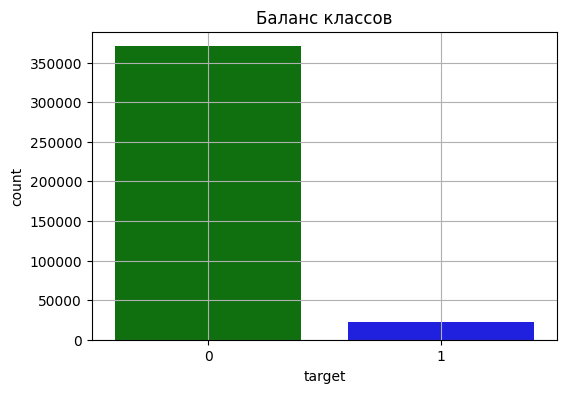

In [59]:
# Исходный баланс классов
balance = y_train.value_counts().reset_index()
display(balance)
balance_plot(balance)
# plt.savefig('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/plots/besline_class_balance.png')

(47882, 12)


,target,count
0,0,25364
1,1,22518


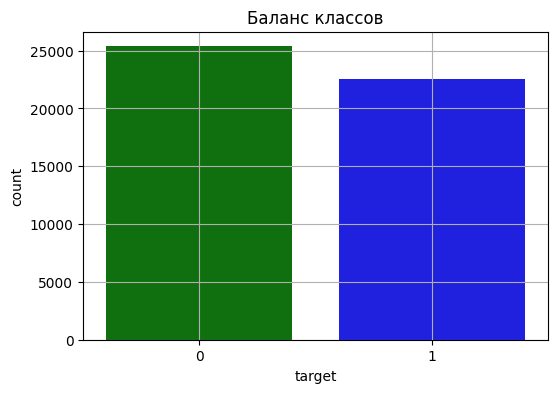

In [60]:
# Рандомно выбираем 3450000 индексов target = 0
idx = np.random.choice(np.array(y_train[y_train == 0].index), size=345000, replace=False)
# Удаляем элементы, индекс которых находится в idx
y_train_cut = y_train.iloc[~y_train.index.isin(idx)]
# Удаляем те же индексы из X_train
X_train_cut = X_train.iloc[y_train_cut.index]
print(X_train_cut.shape)
# Сбрасываем индексы
X_train_cut = X_train_cut.reset_index(drop=True)
y_train_cut = y_train_cut.reset_index(drop=True)

# Итоговый баланс классов
balance = y_train_cut.value_counts().reset_index()
display(balance)
balance_plot(balance)
# plt.savefig('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/plots/new_class_balance.png')

## One-hot кодирование признаков 'utm_medium', 'device_category', 'device_browser'

In [61]:
# Кодирование X_train
# Признаки для one_hot кодирования
ohe_features = ['utm_medium', 'device_category', 'device_browser']
# Создаем объект OneHotEncoder
encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
# Трансформируем признаки и присваиваем имена столбцов таблицы
data_encode = encoder.fit_transform(X_train_cut[ohe_features])
column_names = encoder.get_feature_names_out(ohe_features)
# Добавляем закодированные признаки в датафрейм
data_encode = pd.DataFrame(data_encode, columns=column_names)
X_train_ohe = pd.concat(
    [X_train_cut.reset_index(drop=True).drop(ohe_features, axis=1), data_encode],
    axis=1
)
print(f'Количество признаков в исходном датасете {X_train_cut.shape}')
print(f'Количество признаков в закодированном датасете {X_train_ohe.shape}')

Количество признаков в исходном датасете (47882, 12)
Количество признаков в закодированном датасете (47882, 27)


In [62]:
# Кодирование X_valid
# Трансформируем признаки и присваиваем имена столбцов таблицы
data_encode = encoder.fit_transform(X_valid[ohe_features])
column_names = encoder.get_feature_names_out(ohe_features)
# Добавляем закодированные признаки в датафрейм
data_encode = pd.DataFrame(data_encode, columns=column_names)
X_valid_ohe = pd.concat(
    [X_valid.reset_index(drop=True).drop(ohe_features, axis=1), data_encode],
    axis=1
)
print(f'Количество признаков в исходном датасете {X_valid.shape}')
print(f'Количество признаков в закодированном датасете {X_valid_ohe.shape}')

Количество признаков в исходном датасете (20679, 12)
Количество признаков в закодированном датасете (20679, 27)


In [63]:
# Кодирование X_test
# Трансформируем признаки и присваиваем имена столбцов таблицы
data_encode = encoder.fit_transform(X_test[ohe_features])
column_names = encoder.get_feature_names_out(ohe_features)
# Добавляем закодированные признаки в датафрейм
data_encode = pd.DataFrame(data_encode, columns=column_names)
X_test_ohe = pd.concat(
    [X_test.reset_index(drop=True).drop(ohe_features, axis=1), data_encode],
    axis=1
)
print(f'Количество признаков в исходном датасете {X_test.shape}')
print(f'Количество признаков в закодированном датасете {X_test_ohe.shape}')

Количество признаков в исходном датасете (177241, 12)
Количество признаков в закодированном датасете (177241, 27)


### Уменьшение размерности для визуализации структуры данных

In [14]:
# Шкалируем данные с помощью StandardScaler и применяем PCA
pipeline_pca = Pipeline([('scaler', preprocessing.StandardScaler()),
                              ('pca', decomposition.PCA(n_components=2))])
X_pca = pipeline_pca.fit_transform(X_train_ohe)
# Смотрим какую долю дисперсии объясняет каждая из компонент
variance = [round(x, 2) for x in pipeline_pca['pca'].explained_variance_ratio_]
variance

[np.float64(0.11), np.float64(0.08)]

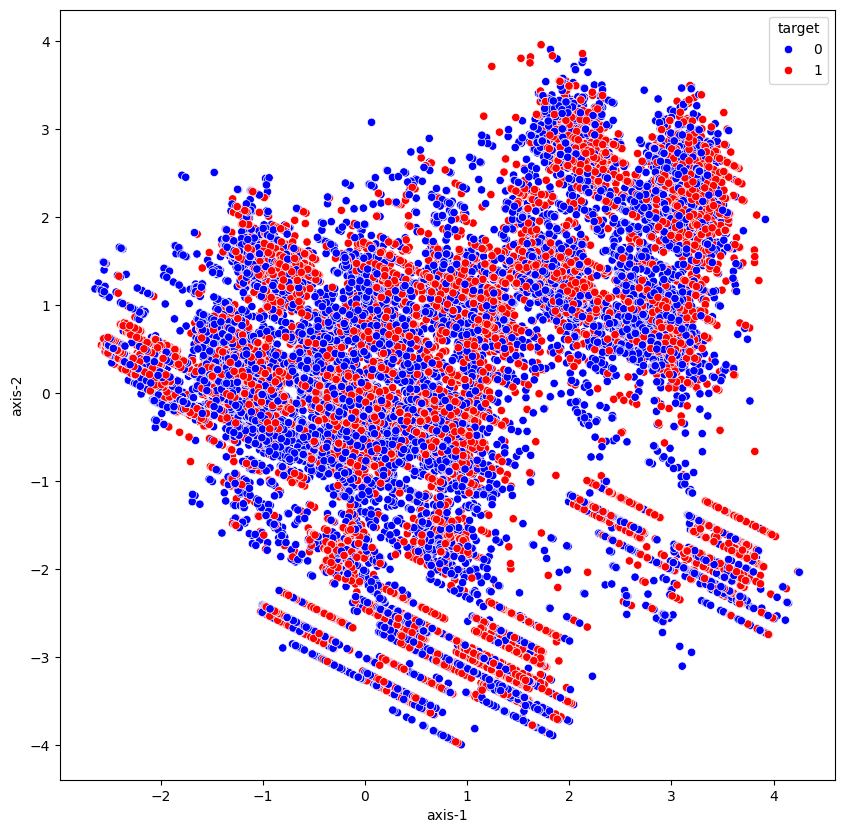

In [15]:
# Создаем датафрейм из трансформированных данных
df_pca = pd.concat([pd.DataFrame(X_pca, columns=['axis-1', 'axis-2']), y_train_cut], axis=1)
# Строим Scatterplot
fig = plt.figure(figsize=(10, 10))
sc_pca = sns.scatterplot(df_pca, x='axis-1', y='axis-2', hue='target', palette=['blue', 'red'])
# plt.savefig('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/plots/scatterplot_2d')

In [ ]:
# Шкалируем данные с помощью StandardScaler и применяем PCA
pipeline_pca_3d = Pipeline([('scaler', preprocessing.StandardScaler()),
                              ('pca', decomposition.PCA(n_components=3))])
X_pca_3d = pipeline_pca_3d.fit_transform(X_train_ohe)
# Смотрим какую долю дисперсии объясняет каждая из компонент
variance = [round(x, 2) for x in pipeline_pca_3d['pca'].explained_variance_ratio_]
variance

[np.float64(0.11), np.float64(0.08), np.float64(0.06)]

In [ ]:
# Создаем датафрейм из трансформированных данных
df_pca_3d = pd.concat([pd.DataFrame(X_pca_3d, columns=['axis-1', 'axis-2', 'axis-3']), y_train_cut], axis=1)
fig = px.scatter_3d(df_pca_3d,
                   x='axis-1',
                   y='axis-2',
                   z='axis-3',
                   color='target',
                  color_continuous_scale = 'viridis',
                   height=1000,
                   width=800)
fig.update_traces(marker_line_color = 'black',
                  marker_line_width = 2)
fig.show()


Output hidden; open in https://colab.research.google.com to view.

Данные линейно неразделимы и классы сильно перемешаны.
Гипотеза: попробуе применить нейросетевой подход

## Создание моделей

Цель ROC-AUC > 0.65

Baseline

3 полносвязных слоя
+ Входной - 27 нейронов
+ Скрытые:
 + Полносвязный - 32 / relu
 + Полносвязный - 64 / relu
+ Выход: Полносвязный - 1 / sigmoid

Оптимизатор: SGD

In [ ]:
# Создание baseline модель
model_baseline = keras.Sequential([
    keras.Input([27]),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_baseline.summary()

model_baseline.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['auc']
              )

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 32
epochs = 50
# Запускаем процесс обучения модели
history_baseline = model_baseline.fit(
    X_train_ohe,  # Обучающие данные
    y_train_cut,  # Истинные метки классов
    batch_size=batch_size,  # Размер мини-пакета
    epochs=epochs,  # Количество эпох обучения
    validation_data=(X_valid_ohe, y_valid), # Валидационные данные
    validation_batch_size=batch_size
    )
# model_baseline.save('models/undersampling/nn_baseline_newdf.keras')

Epoch 1/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - auc: 0.5471 - loss: 0.6949 - val_auc: 0.6450 - val_loss: 0.5048
Epoch 2/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.6105 - loss: 0.6719 - val_auc: 0.6719 - val_loss: 0.5876
Epoch 3/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.6313 - loss: 0.6646 - val_auc: 0.6741 - val_loss: 0.7876
Epoch 4/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.6434 - loss: 0.6586 - val_auc: 0.6826 - val_loss: 0.5794
Epoch 5/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.6440 - loss: 0.6582 - val_auc: 0.6805 - val_loss: 0.6648
Epoch 6/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.6517 - loss: 0.6551 - val_auc: 0.6841 - val_loss: 0.5456
Epoch 7/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.6557 - loss: 0.6524 - val_auc: 0.6861 - val_loss: 0.5736
Epoch 8/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - auc: 0.6547 - loss: 0.6528 - val_auc: 0.6813 - val_loss: 0.4448
Epoch 9/50
1497/1497 ━━━━━━━━━━━━━━━━

In [ ]:
score = model_baseline.evaluate(X_test_ohe, y_test)
# Выводим результаты оценки
print("Test loss:", score[0])
print("Test roc_auc:", round(score[1], 2))

5539/5539 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - auc: 0.6952 - loss: 0.6152
Test loss: 0.6155173778533936
Test roc_auc: 0.7


In [ ]:
def train_plot(history_baseline):
    plt.figure(figsize=(16, 10))
    plt.subplot(2,1,1)
    plt.plot(history_baseline.history['auc'], color='blue')
    plt.plot(history_baseline.history['val_auc'], color='green')
    plt.title('AUC модели')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='lower right')
    plt.grid()
    plt.show()

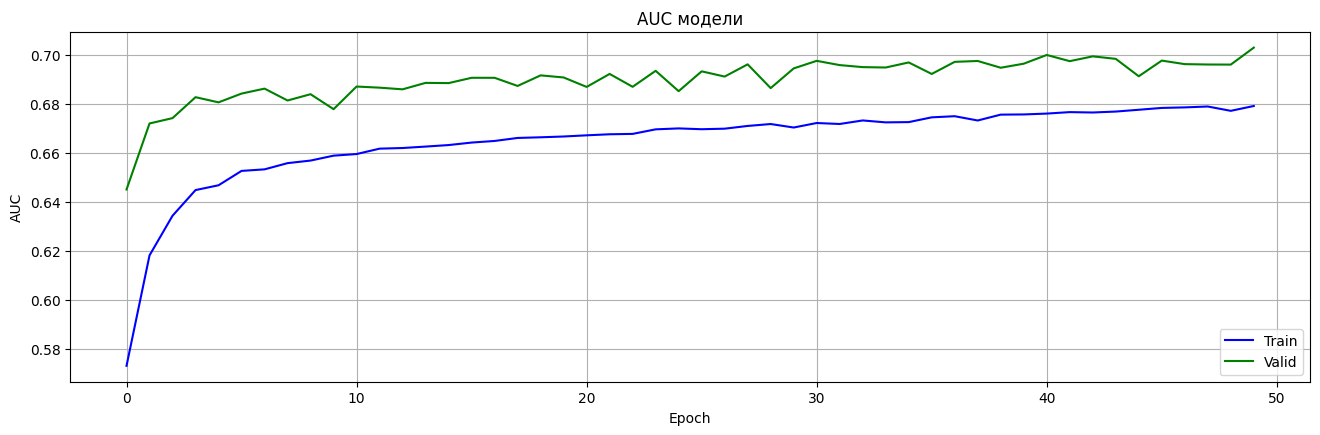

<Figure size 640x480 with 0 Axes>

In [ ]:
# Строим график обучения
train_plot(history_baseline)
# plt.savefig('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/plots/besline_train.png')

In [ ]:
# Функция для визуализции roc-auc кривой
def roc_auc_plot(fpr_keras, tpr_keras):
    roc_auc = metrics.auc(fpr_keras, tpr_keras)
    # Создаем график
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_keras, tpr_keras, color='darkorange',
             label=f'ROC кривая (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Линия случайного угадывания
    # Оформляем график
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

5539/5539 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


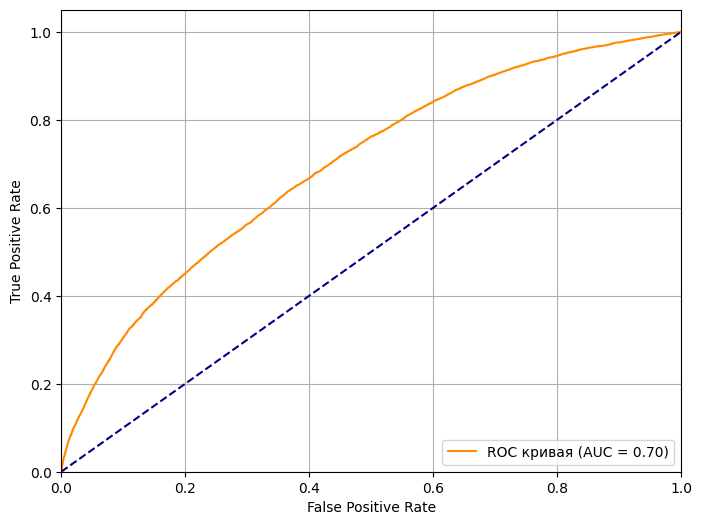

In [ ]:
# Строим график roc-auc
y_pred_keras = model_baseline.predict(X_test_ohe).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
roc_auc_plot(fpr_keras, tpr_keras)

## Тюнигн baseline

Baseline tune

3 полносвязных слоя
+ Входной - 27 нейронов
+ Скрытые:
 + Полносвязный - 32 / relu / L2 0.001
 + Полносвязный - 64 / relu
+ Выход: Полносвязный - 1 / sigmoid / L2 0.001

Оптимизатор: SGD (learning rate=0.01, momentum=0.1)

In [ ]:
# Создание baseline модель
model_baseline_tune = keras.Sequential([
    keras.Input([27]),
    layers.Dense(32, activation='leaky_relu', activity_regularizer=regularizers.L2(0.0001)),
    layers.Dense(64, activation='leaky_relu', bias_regularizer=regularizers.L2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

model_baseline_tune.summary()
# Настройка оптимизатора
optimizer = keras.optimizers.SGD(
    learning_rate=0.001,
    momentum=0.1,
    name="SGD"
    )

# Компиляция модели с учетом весов классов
model_baseline_tune.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['auc']
              )

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 32)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 32
epochs = 50
# Запускаем процесс обучения модели
history_baseline_tune = model_baseline_tune.fit(
    X_train_ohe,  # Обучающие данные
    y_train_cut,  # Истинные метки классов
    batch_size=batch_size,  # Размер мини-пакета
    epochs=epochs,  # Количество эпох обучения
    validation_data=(X_valid_ohe, y_valid), # Валидационные данные
    validation_batch_size=batch_size
    )
model_baseline.save('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/model_keras/baseline_tune.keras')

Epoch 1/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.5578 - loss: 0.7497 - val_auc: 0.6275 - val_loss: 0.6411
Epoch 2/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.6046 - loss: 0.6839 - val_auc: 0.6462 - val_loss: 0.5876
Epoch 3/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.6244 - loss: 0.6735 - val_auc: 0.6688 - val_loss: 0.5846
Epoch 4/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.6384 - loss: 0.6659 - val_auc: 0.6619 - val_loss: 0.4807
Epoch 5/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.6444 - loss: 0.6625 - val_auc: 0.6780 - val_loss: 0.7721
Epoch 6/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.6477 - loss: 0.6611 - val_auc: 0.6594 - val_loss: 1.0932
Epoch 7/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - auc: 0.6521 - loss: 0.6589 - val_auc: 0.6802 - val_loss: 0.5332
Epoch 8/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.6542 - loss: 0.6567 - val_auc: 0.6893 - val_loss: 0.6733
Epoch 9/50
1497/1497 ━━━━━━━━━━━━━━━━━━

In [ ]:
score = model_baseline_tune.evaluate(X_test_ohe, y_test)
# Выводим результаты оценки
print("Test loss:", score[0])
print("Test roc_auc:", round(score[1], 2))

5539/5539 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - auc: 0.6812 - loss: 0.5012
Test loss: 0.50179523229599
Test roc_auc: 0.68


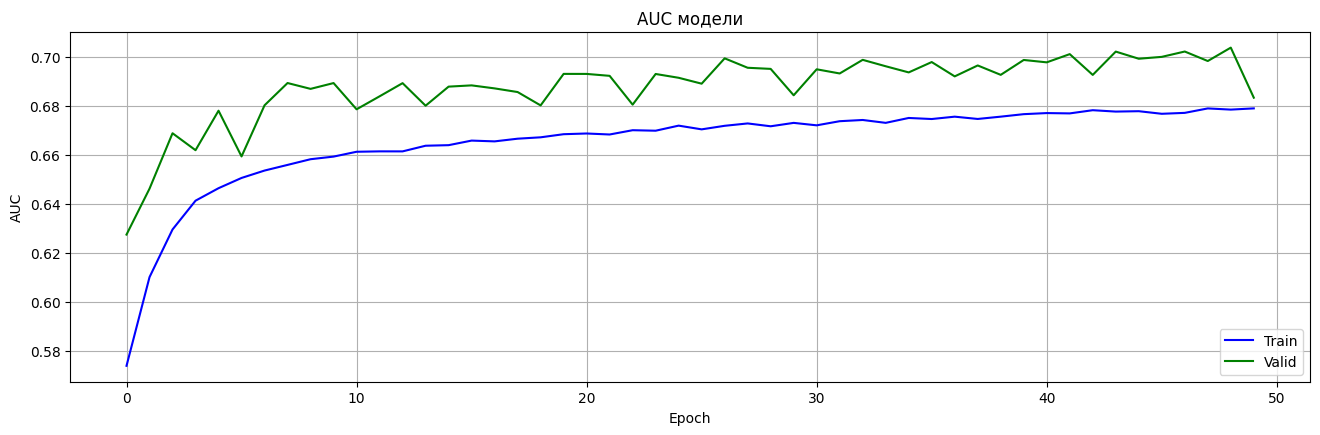

<Figure size 640x480 with 0 Axes>

In [ ]:
# Строим график обучения
train_plot(history_baseline_tune)
# plt.savefig('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/plots/besline_tune_train.png')

5539/5539 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


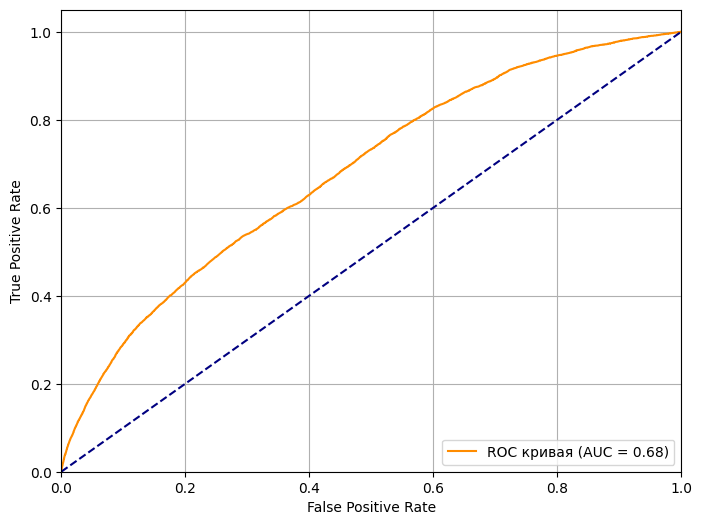

<Figure size 640x480 with 0 Axes>

In [ ]:
# Строим график roc-auc
y_pred_keras = model_baseline_tune.predict(X_test_ohe).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
roc_auc_plot(fpr_keras, tpr_keras)
plt.savefig('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/plots/besline_tune_auc.png')

## Эксперимент 1

+ Входной слой - 27
+ Скрытые слои
  + Полносвязный - 32 / tanh
  + Полносвязный - 32 / tanh
  + Полносвязный - 64 / tanh / L2 - 0.01
+ Выходной - 1 / sigmoid

оптимизатор SGD (momentum=0.2)

+ Добавлен 1 слой для повышения качества метрики
+ функция активации tanh, так как принимает значения (-1, 1), а закодированный эмбеддингами признаки в диапазоне (-1, 0). Возможно relu их отключала
+ Регуляризация L2 - для уменьшения переобучения
+ Моментум увеличен, потому что возможно алгоритм застревает в локальном минимуме

In [ ]:
# Создание модель exp1
model_exp1 = keras.Sequential([
    keras.Input([27]),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(64, activation='tanh', activity_regularizer=regularizers.L2(0.01)),
    layers.Dense(1, activation='sigmoid')
])

model_exp1.summary()
# Настройка оптимизатора
optimizer = keras.optimizers.SGD(
    momentum=0.2,
    name="SGD"
    )

# Компиляция модели с учетом весов классов
model_exp1.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['auc']
              )

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 32)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,129 (16.13 KB)

 Trainable params: 4,129 (16.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 32
epochs = 50
# Запускаем процесс обучения модели
history_exp1 = model_exp1.fit(
    X_train_ohe,  # Обучающие данные
    y_train_cut,  # Истинные метки классов
    batch_size=batch_size,  # Размер мини-пакета
    epochs=epochs,  # Количество эпох обучения
    validation_data=(X_valid_ohe, y_valid), # Валидационные данные
    validation_batch_size=batch_size
    )
model_exp1.save('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/model_keras/model_exp1.keras')

Epoch 1/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.5321 - loss: 0.8390 - val_auc: 0.5700 - val_loss: 0.6312
Epoch 2/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - auc: 0.5235 - loss: 0.6972 - val_auc: 0.5878 - val_loss: 0.6673
Epoch 3/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.5384 - loss: 0.6938 - val_auc: 0.5998 - val_loss: 0.6962
Epoch 4/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.5587 - loss: 0.6912 - val_auc: 0.6260 - val_loss: 0.6408
Epoch 5/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - auc: 0.5814 - loss: 0.6899 - val_auc: 0.6464 - val_loss: 0.6489
Epoch 6/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.6099 - loss: 0.6849 - val_auc: 0.6658 - val_loss: 0.5858
Epoch 7/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.6258 - loss: 0.6810 - val_auc: 0.6812 - val_loss: 0.5987
Epoch 8/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.6279 - loss: 0.6787 - val_auc: 0.6681 - val_loss: 0.7453
Epoch 9/50
1497/1497 ━━━━━━━━━━━━━━━━━━━

In [ ]:
score = model_exp1.evaluate(X_test_ohe, y_test)
# Выводим результаты оценки
print("Test loss:", score[0])
print("Test roc_auc:", round(score[1], 2))

5539/5539 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - auc: 0.6889 - loss: 0.6058
Test loss: 0.6060196757316589
Test roc_auc: 0.69


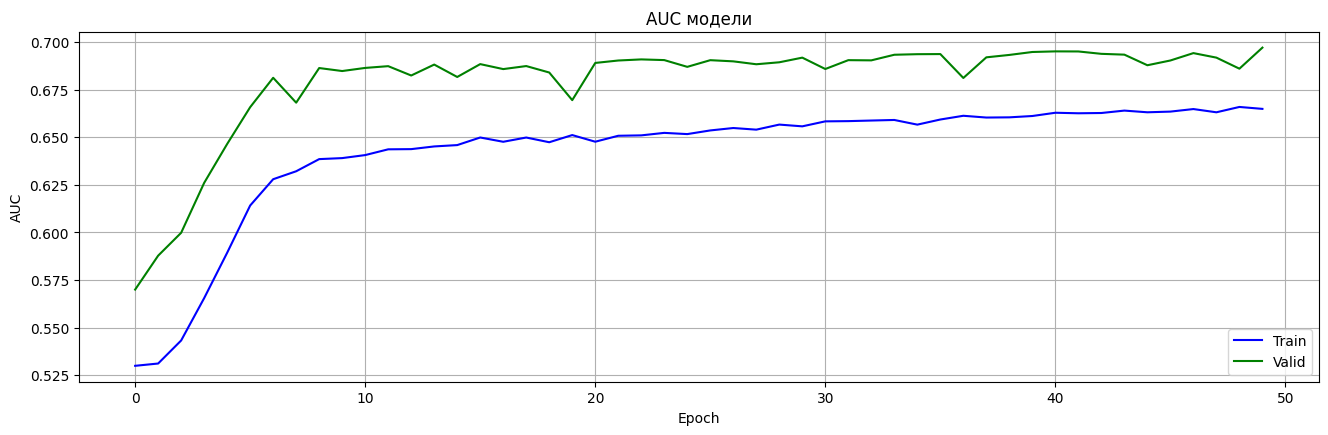

<Figure size 640x480 with 0 Axes>

In [ ]:
# Строим график обучения
train_plot(history_exp1)
plt.savefig('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/plots/model_exp1_train.png')

5539/5539 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


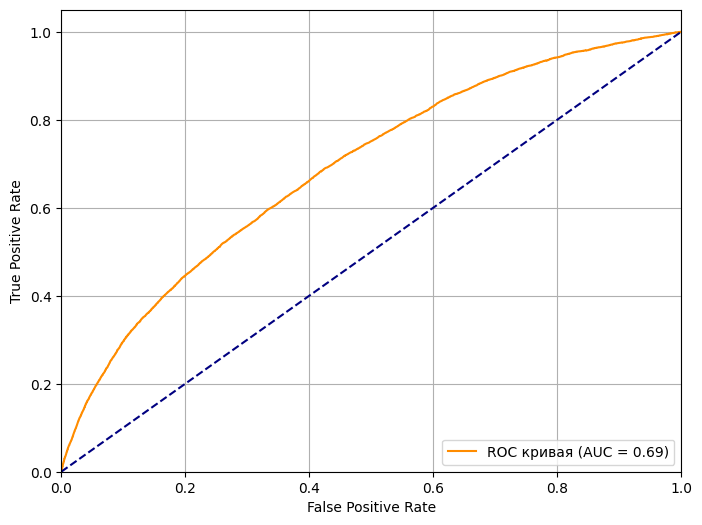

<Figure size 640x480 with 0 Axes>

In [ ]:
# Строим график roc-auc
y_pred_keras = model_exp1.predict(X_test_ohe).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
roc_auc_plot(fpr_keras, tpr_keras)
plt.savefig('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/plots/model_exp1_auc.png')

## Эксперимент 2

+ Входной слой - 27
+ Скрытые слои
  + Полносвязный - 32 / tanh
  + Полносвязный - 64 / tanh
  + Полносвязный - 64 / tanh / L2 - 0.01
+ Выходной - 1 / sigmoid

оптимизатор SGD (momentum=0.0001)

+ Увеличено количество нейронов на 2 скрытом слое до 64
+ Моментум уменьшен до 0.0001

In [ ]:
# Создание model exp 2
model_exp2 = keras.Sequential([
    keras.Input([27]),
    layers.Dense(32, activation='tanh'),
    layers.Dense(64, activation='tanh'), # 64 нейрона
    layers.Dense(64, activation='tanh', activity_regularizer=regularizers.L2(0.01)),
    layers.Dense(1, activation='sigmoid')
])
model_exp2.summary()

optimizer = keras.optimizers.SGD(
    momentum=0.0001,
    name="SGD"
    )

model_exp2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['auc']
              )

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 32)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,233 (28.25 KB)

 Trainable params: 7,233 (28.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 32
epochs = 50
# Запускаем процесс обучения модели
history_exp2= model_exp2.fit(
    X_train_ohe,  # Обучающие данные
    y_train_cut,  # Истинные метки классов
    batch_size=batch_size,  # Размер мини-пакета
    epochs=epochs,  # Количество эпох обучения
    validation_data=(X_valid_ohe, y_valid), # Валидационные данные
    validation_batch_size=batch_size
    )
model_exp2.save('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/model_keras/model_exp2.keras')

Epoch 1/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - auc: 0.4923 - loss: 0.8299 - val_auc: 0.5275 - val_loss: 0.7004
Epoch 2/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.5032 - loss: 0.6950 - val_auc: 0.5296 - val_loss: 0.6265
Epoch 3/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - auc: 0.5079 - loss: 0.6936 - val_auc: 0.5564 - val_loss: 0.6073
Epoch 4/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - auc: 0.5147 - loss: 0.6936 - val_auc: 0.5665 - val_loss: 0.5949
Epoch 5/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.5136 - loss: 0.6932 - val_auc: 0.5674 - val_loss: 0.6560
Epoch 6/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.5291 - loss: 0.6927 - val_auc: 0.5777 - val_loss: 0.6425
Epoch 7/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.5377 - loss: 0.6918 - val_auc: 0.5801 - val_loss: 0.5565
Epoch 8/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.5463 - loss: 0.6915 - val_auc: 0.5934 - val_loss: 0.6854
Epoch 9/50
1497/1497 ━━━━━━━━━━━━━━━━━━

In [ ]:
score = model_exp2.evaluate(X_test_ohe, y_test)
# Выводим результаты оценки
print("Test loss:", score[0])
print("Test roc_auc:", round(score[1], 2))

5539/5539 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - auc: 0.6823 - loss: 0.6647
Test loss: 0.6651884317398071
Test roc_auc: 0.68


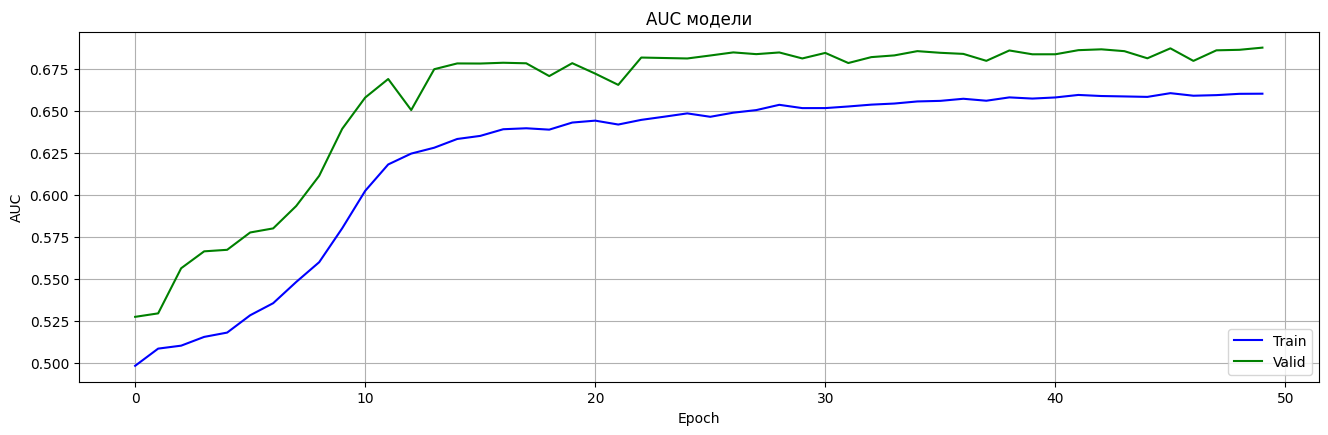

<Figure size 640x480 with 0 Axes>

In [ ]:
# Строим график обучения
train_plot(history_exp2)
plt.savefig('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/plots/model_exp2_train.png')

5539/5539 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


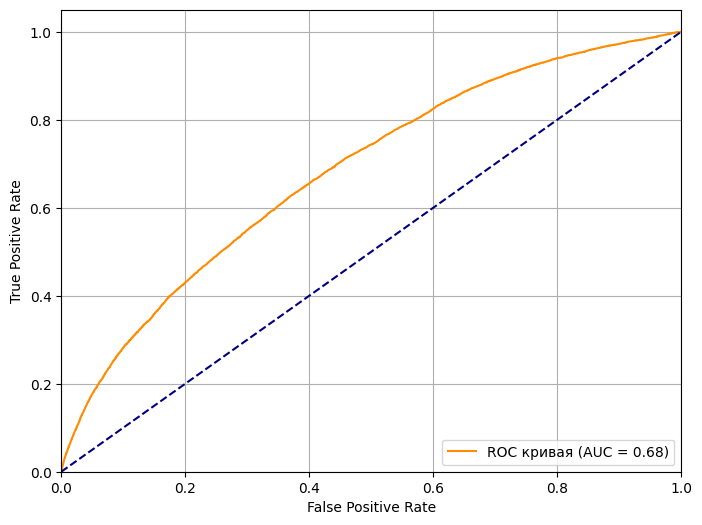

<Figure size 640x480 with 0 Axes>

In [ ]:
# Строим график roc-auc
y_pred_keras = model_exp2.predict(X_test_ohe).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
roc_auc_plot(fpr_keras, tpr_keras)
plt.savefig('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/plots/model_exp2_auc.png')

## Эксперимент 3

+ Входной слой - 27
+ Скрытые слои
  + Полносвязный - 32 / tanh
  + Полносвязный - 64 / tanh
  + Полносвязный - 128 / tanh / L2 - 0.01
  + Полносвязный - 32 / tanh
+ Выходной - 1 / sigmoid / L2 - 0.01

оптимизатор adam

+ Увеличено количество скрытых слоев и нейронов, с целью увеличить метрику.
+ Количество нейронов на последнем полносвязном слое сокращено для стабилизации.
+ Регуляризация на самом большом по количеству нейрнонов слое и на выходном - для предотвращения переобучения
+ Оптимизатор adam - сеть более стабильна, поэтому можно подключить adam для улучшения сходимости

In [ ]:
# Модель exp 3
model_exp3 = keras.Sequential([
    keras.Input([27]),
    layers.Dense(32, activation='tanh'),
    layers.Dense(64, activation='tanh'),
    layers.Dense(128, activation='tanh', activity_regularizer=regularizers.L2(0.01)),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1, activation='sigmoid', activity_regularizer=regularizers.L2(0.01))
])

model_exp3.summary()

model_exp3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['auc']
              )

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 32)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,489 (60.50 KB)

 Trainable params: 15,489 (60.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 32
epochs = 100
# Запускаем процесс обучения модели
history_exp3= model_exp3.fit(
    X_train_ohe,  # Обучающие данные
    y_train_cut,  # Истинные метки классов
    batch_size=batch_size,  # Размер мини-пакета
    epochs=epochs,  # Количество эпох обучения
    validation_data=(X_valid_ohe, y_valid), # Валидационные данные
    validation_batch_size=batch_size
    )
model_exp3.save('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/model_keras/model_exp3.keras')

Epoch 1/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - auc: 0.5833 - loss: 0.9545 - val_auc: 0.6751 - val_loss: 0.3597
Epoch 2/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.6519 - loss: 0.7329 - val_auc: 0.6889 - val_loss: 0.5956
Epoch 3/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.6618 - loss: 0.7216 - val_auc: 0.6918 - val_loss: 0.5238
Epoch 4/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.6696 - loss: 0.7190 - val_auc: 0.6915 - val_loss: 0.4907
Epoch 5/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.6735 - loss: 0.7160 - val_auc: 0.6985 - val_loss: 0.5975
Epoch 6/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - auc: 0.6737 - loss: 0.7137 - val_auc: 0.7016 - val_loss: 0.5010
Epoch 7/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.6808 - loss: 0.7119 - val_auc: 0.7023 - val_loss: 0.5366
Epoch 8/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.6840 - loss: 0.7091 - val_auc: 0.7027 - val_loss: 0.4650
Epoch 9/100
1497/1497 ━━━━━━━━

In [ ]:
score = model_exp3.evaluate(X_test_ohe, y_test)
# Выводим результаты оценки
print("Test loss:", score[0])
print("Test roc_auc:", round(score[1], 2))

5539/5539 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - auc: 0.7045 - loss: 0.5388
Test loss: 0.5395125150680542
Test roc_auc: 0.71


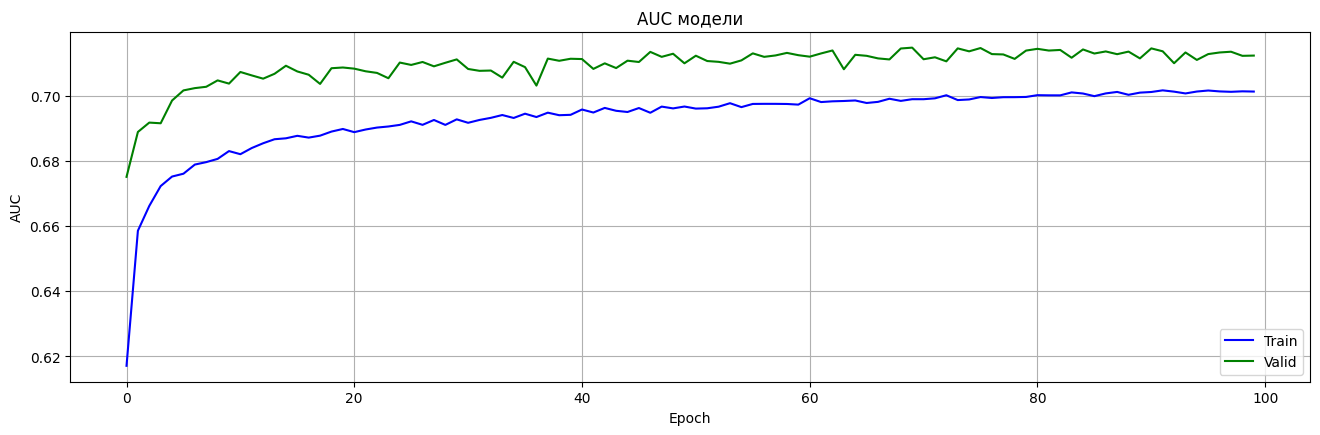

<Figure size 640x480 with 0 Axes>

In [ ]:
# Строим график обучения
train_plot(history_exp3)
plt.savefig('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/plots/model_exp3_train.png')

5539/5539 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


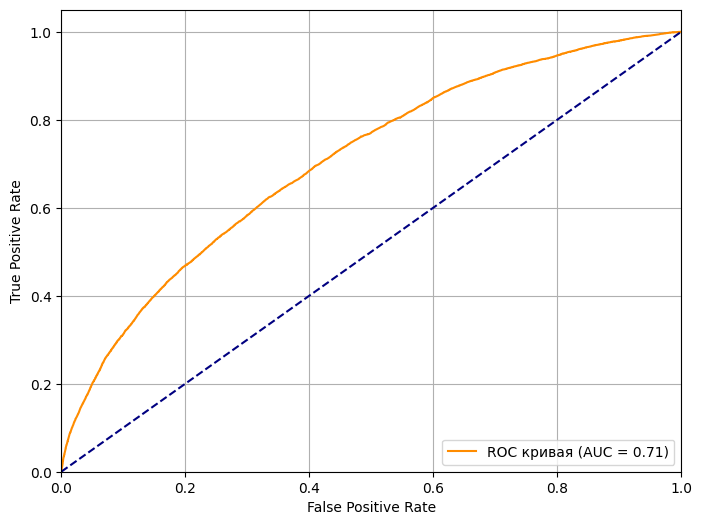

<Figure size 640x480 with 0 Axes>

In [ ]:
# Строим график roc-auc
y_pred_keras = model_exp3.predict(X_test_ohe).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
roc_auc_plot(fpr_keras, tpr_keras)
plt.savefig('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/plots/model_exp3_auc.png')

## Эксперимент 4

+ Входной слой - 27
+ Скрытые слои
  + Полносвязный - 32 / tanh
  + Полносвязный - 64 / tanh
  + Полносвязный - 128 / tanh / L2 - 0.01
  + Полносвязный - 128 / tanh / L2 - 0.01
  + Полносвязный - 64 / tanh
  + Полносвязный - 32 / tanh
+ Выходной - 1 / sigmoid / L2 - 0.01

оптимизатор adam

+ Увеличено количество скрытых слоев и нейронов, с целью увеличить метрику.
+ Количество нейронов на последнем полносвязном слое сокращено для стабилизации.
+ Регуляризация на самом большом по количеству нейрнонов слое и на выходном - для предотвращения переобучения
+ Оптимизатор adam - сеть более стабильна, поэтому можно подключить adam для улучшения сходимости

In [ ]:
# Model exp 4
model_exp4 = keras.Sequential([
    keras.Input([27]),
    layers.Dense(32, activation='tanh'),
    layers.Dense(64, activation='tanh'),
    layers.Dense(128, activation='tanh', activity_regularizer=regularizers.L2(0.01)),
    layers.Dense(128, activation='tanh', activity_regularizer=regularizers.L2(0.01)),
    layers.Dense(64, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1, activation='sigmoid', activity_regularizer=regularizers.L2(0.01))
])

model_exp4.summary()
model_exp4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['auc']
              )

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 32)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,209 (149.25 KB)

 Trainable params: 38,209 (149.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 32
epochs = 100
# Запускаем процесс обучения модели
history_exp4= model_exp4.fit(
    X_train_ohe,  # Обучающие данные
    y_train_cut,  # Истинные метки классов
    batch_size=batch_size,  # Размер мини-пакета
    epochs=epochs,  # Количество эпох обучения
    validation_data=(X_valid_ohe, y_valid), # Валидационные данные
    validation_batch_size=batch_size
    )
model_exp4.save('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/model_keras/model_exp4.keras')

Epoch 1/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - auc: 0.5953 - loss: 1.1202 - val_auc: 0.6823 - val_loss: 0.5388
Epoch 2/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.6517 - loss: 0.7360 - val_auc: 0.6741 - val_loss: 0.8005
Epoch 3/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - auc: 0.6617 - loss: 0.7280 - val_auc: 0.6913 - val_loss: 0.6571
Epoch 4/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - auc: 0.6679 - loss: 0.7249 - val_auc: 0.6937 - val_loss: 0.5711
Epoch 5/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.6656 - loss: 0.7221 - val_auc: 0.6971 - val_loss: 0.5342
Epoch 6/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.6731 - loss: 0.7192 - val_auc: 0.7005 - val_loss: 0.5786
Epoch 7/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.6732 - loss: 0.7174 - val_auc: 0.6999 - val_loss: 0.5510
Epoch 8/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.6742 - loss: 0.7126 - val_auc: 0.6989 - val_loss: 0.5445
Epoch 9/100
1497/1497 ━━━━━━━━

In [ ]:
score = model_exp4.evaluate(X_test_ohe, y_test)
# Выводим результаты оценки
print("Test loss:", score[0])
print("Test roc_auc:", round(score[1], 2))

5539/5539 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - auc: 0.7041 - loss: 0.5450
Test loss: 0.5458789467811584
Test roc_auc: 0.7


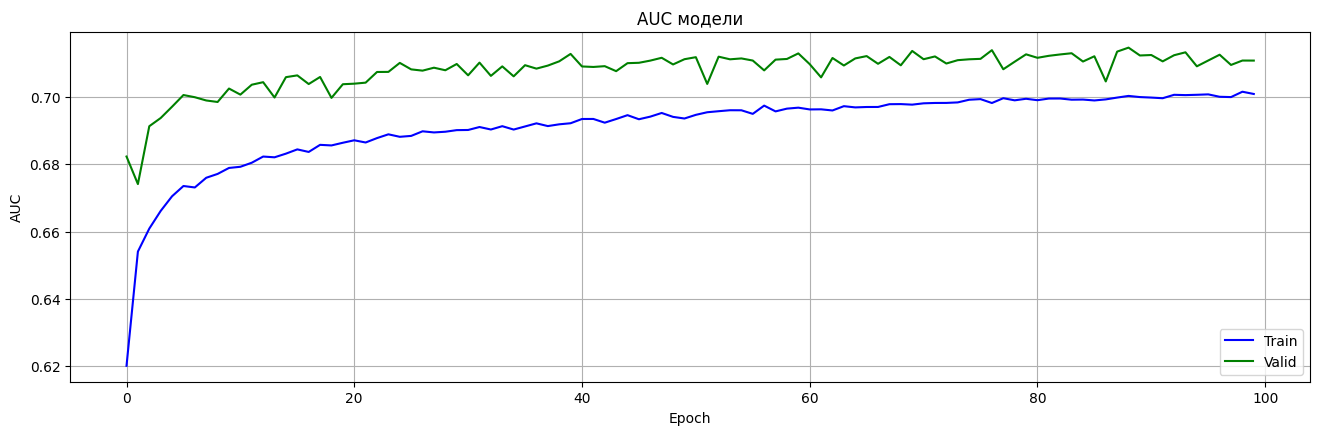

<Figure size 640x480 with 0 Axes>

In [ ]:
# Строим график обучения
train_plot(history_exp4)
plt.savefig('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/plots/model_exp4_train.png')

5539/5539 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


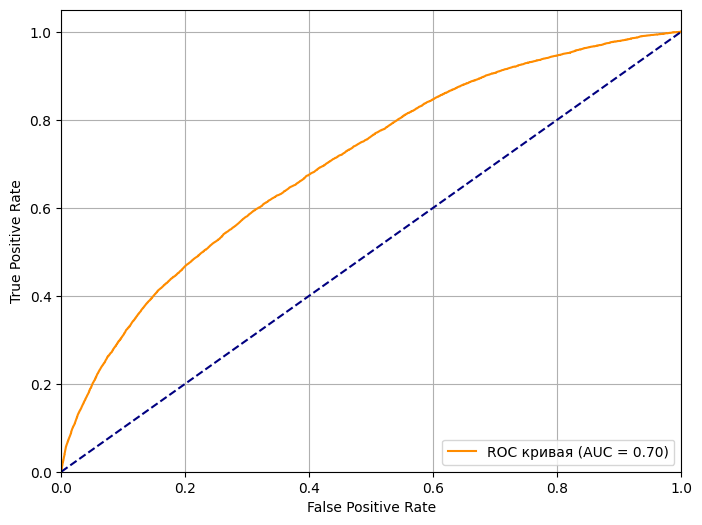

<Figure size 640x480 with 0 Axes>

In [ ]:
# Строим график roc-auc
y_pred_keras = model_exp4.predict(X_test_ohe).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
roc_auc_plot(fpr_keras, tpr_keras)
plt.savefig('/content/drive/MyDrive/ТГУ/HACKATON_SBER/Dmitriy/plots/model_exp4_auc.png')

## Эксперимент 5 Bagging нейронных сетей

Обучим 5 нейронных сетей разной архитектуры. Объединим по алгоритму бэггинга 3 лучшие сети.

Гипотеза: бэггинг по 3 моделям может дать метрику больше, чем самая сильная одиночная модель, то есть больше 0.71

In [16]:
# Модель 1
net_1 = keras.Sequential([
    keras.Input([27]),
    layers.Dense(32, activation='tanh'),
    layers.Dense(64, activation='tanh'),
    layers.Dense(1, activation='sigmoid')
])
# Модель 2
net_2 = keras.Sequential([
    keras.Input([27]),
    layers.Dense(32, activation='tanh'),
    layers.Dense(128, activation='tanh'),
    layers.Dense(256, activation='tanh'),
    layers.Dense(1, activation='sigmoid')
])

# Модель 3
net_3 = keras.Sequential([
    keras.Input([27]),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1, activation='sigmoid')
])

# Модель 4
net_4 = keras.Sequential([
    keras.Input([27]),
    layers.Dense(32, activation='tanh'),
    layers.Dense(64, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(64, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1, activation='sigmoid')
])

# Модель 5
net_5 = keras.Sequential([
    keras.Input([27]),
    layers.Dense(64, activation='tanh'),
    layers.Dense(512, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1, activation='sigmoid')
])

In [17]:
# Компилируем модели
net_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])
net_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])
net_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])
net_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])
net_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])

In [18]:
batch_size = 32
epochs = 30
# Запускаем процесс обучения модели
print('Net 1')
history_1 = net_1.fit(X_train_ohe, y_train_cut, batch_size=batch_size, epochs=epochs, validation_data=(X_valid_ohe, y_valid), validation_batch_size=batch_size)
print('Net 2')
history_2 = net_2.fit(X_train_ohe, y_train_cut, batch_size=batch_size, epochs=epochs, validation_data=(X_valid_ohe, y_valid), validation_batch_size=batch_size)
print('Net 3')
history_3 = net_3.fit(X_train_ohe, y_train_cut, batch_size=batch_size, epochs=epochs, validation_data=(X_valid_ohe, y_valid), validation_batch_size=batch_size)
print('Net 4')
history_4 = net_4.fit(X_train_ohe, y_train_cut, batch_size=batch_size, epochs=epochs, validation_data=(X_valid_ohe, y_valid), validation_batch_size=batch_size)
print('Net 5')
history_5 = net_5.fit(X_train_ohe, y_train_cut, batch_size=batch_size, epochs=epochs, validation_data=(X_valid_ohe, y_valid), validation_batch_size=batch_size)

Net 1
Epoch 1/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - auc: 0.6145 - loss: 0.6679 - val_auc: 0.6839 - val_loss: 0.6091
Epoch 2/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.6717 - loss: 0.6438 - val_auc: 0.6947 - val_loss: 0.6029
Epoch 3/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.6725 - loss: 0.6435 - val_auc: 0.6970 - val_loss: 0.6538
Epoch 4/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.6770 - loss: 0.6399 - val_auc: 0.7002 - val_loss: 0.5833
Epoch 5/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.6826 - loss: 0.6367 - val_auc: 0.7015 - val_loss: 0.5032
Epoch 6/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - auc: 0.6814 - loss: 0.6371 - val_auc: 0.7012 - val_loss: 0.6183
Epoch 7/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.6915 - loss: 0.6309 - val_auc: 0.7017 - val_loss: 0.5899
Epoch 8/30
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.6871 - loss: 0.6337 - val_auc: 0.7049 - val_loss: 0.6175
Epoch 9/30
1497/1497 ━━━━━━━━━━━

In [20]:
# Оцениваем качество модели на валидационной выборке
# Выполняем оценку модели
score_1 = net_1.evaluate(X_test_ohe, y_test)
# Выводим результаты оценки
print("Model 1 Test loss:", score_1[0])
print("Model 1 Test auc:", round(score_1[1] * 100, 2), "%")
print("-"*30)

score_2 = net_2.evaluate(X_test_ohe, y_test)
# Выводим результаты оценки
print("Model 2 Test loss:", score_2[0])
print("Model 2 Test auc:", round(score_2[1] * 100, 2), "%")
print("-"*30)

score_3 = net_3.evaluate(X_test_ohe, y_test)
# Выводим результаты оценки
print("Model 3 Test loss:", score_3[0])
print("Model 3 Test auc:", round(score_3[1] * 100, 2), "%")
print("-"*30)

score_4 = net_4.evaluate(X_test_ohe, y_test)
# Выводим результаты оценки
print("Model 4 Test loss:", score_4[0])
print("Model 4 Test auc:", round(score_4[1] * 100, 2), "%")
print("-"*30)

score_5 = net_5.evaluate(X_test_ohe, y_test)
# Выводим результаты оценки
print("Model 5 Test loss:", score_5[0])
print("Model 5 Test auc:", round(score_5[1] * 100, 2), "%")
print("-"*30)

5539/5539 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - auc: 0.7059 - loss: 0.5850
Model 1 Test loss: 0.5857084393501282
Model 1 Test auc: 70.53 %
------------------------------
5539/5539 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - auc: 0.7072 - loss: 0.6478
Model 2 Test loss: 0.6484312415122986
Model 2 Test auc: 70.77 %
------------------------------
5539/5539 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - auc: 0.7067 - loss: 0.5691
Model 3 Test loss: 0.5697983503341675
Model 3 Test auc: 70.72 %
------------------------------
5539/5539 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - auc: 0.7037 - loss: 0.5902
Model 4 Test loss: 0.59034663438797
Model 4 Test auc: 70.47 %
------------------------------
5539/5539 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - auc: 0.6973 - loss: 0.6128
Model 5 Test loss: 0.6129561066627502
Model 5 Test auc: 69.95 %
------------------------------


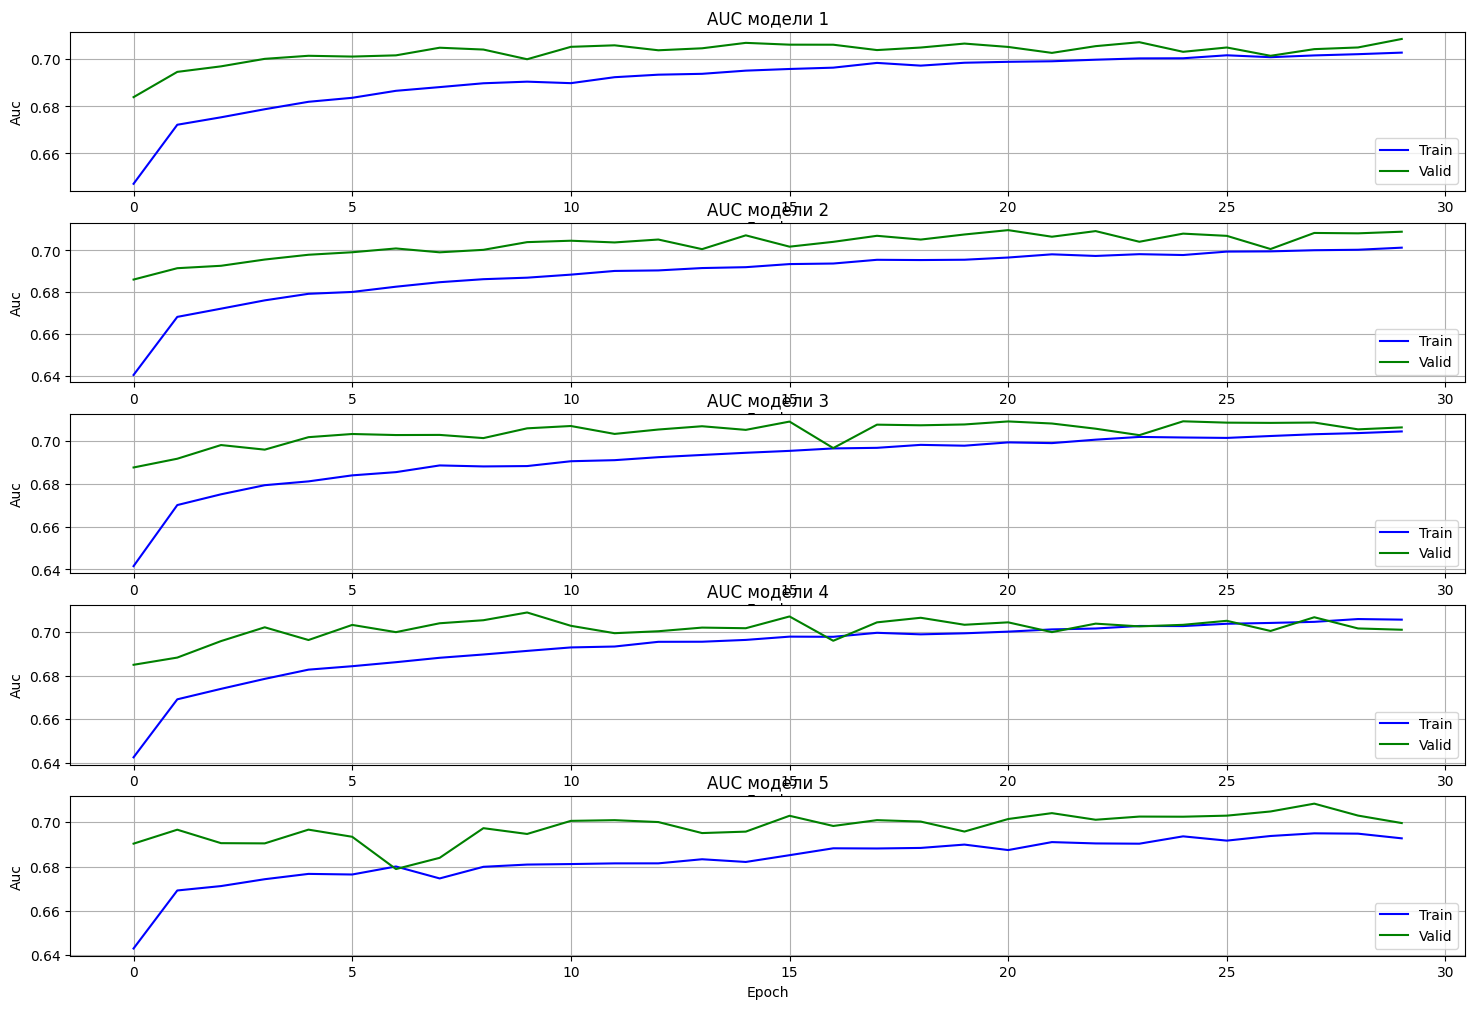

In [23]:
# Визуализируем качество моделей
fig, axes = plt.subplots(5, 1, figsize=(18, 12))
for ax, nn, i in zip(axes, [history_1, history_2, history_3, history_4, history_5], range(1, 6)):
    ax.plot(nn.history['auc'], color='blue')
    ax.plot(nn.history['val_auc'], color='green')
    ax.set_title(f'AUC модели {i}')
    ax.set_ylabel('Auc')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Valid'], loc='lower right')
    ax.grid()
plt.show()

In [24]:
# Получим ответы каждой сети
ot_1 = net_1.predict(X_test_ohe, verbose=0) # Ответ model 1
ot_2 = net_2.predict(X_test_ohe, verbose=0) # Ответ model 2
ot_3 = net_3.predict(X_test_ohe, verbose=0) # Ответ model 3
ot_4 = net_4.predict(X_test_ohe, verbose=0) # Ответ model 4
ot_5 = net_5.predict(X_test_ohe, verbose=0) # Ответ model 4

In [30]:
# Тестируем 3 лучших нейронных сети:
# net_1, net_2, net_3
# Получаем среднее значение ответа
ot_avg_best_models = (ot_1 + ot_2 + ot_3) / 3
auc = metrics.roc_auc_score(y_test, ot_avg_best_models)
print('3 лучших модели')
print(f'Test AUC: {round(auc, 2)}') # AUC

3 лучших модели
Test AUC: 0.71


## Эксперимент Random Forest Classifier

In [77]:
class TrainModel:
    """
    Класс для тренировки модели машинного обучения и оценки её качества различными метриками.

    Параметры конструктора (__init__):
    - X_train: Обучающий набор признаков (X).
    - X_valid: Валидный (тестовый) набор признаков (X).
    - y_train: Целевые значения для обучающего набора (y).
    - y_valid: Целевые значения для валидного (тестового) набора (y).
    - model: Объект используемой модели ML (например, LogisticRegression, RandomForestClassifier и др.).
    """

    def __init__(self, X_train, X_valid, y_train, y_valid, model):
        self.model = model                  # Модель для обучения
        self.X_train = X_train              # Обучающие признаки
        self.X_valid = X_valid              # Тестовые признаки
        self.y_train = y_train              # Обучающая целевая переменная
        self.y_valid = y_valid              # Тестовая целевая переменная
        self.y_train_predict = None         # Предсказанные значения для обучающей выборки
        self.y_valid_predict = None         # Предсказанные значения для тестовой выборки

    def get_dict_metrics(self):
        """
        Метод возвращает словарь с основными метрическими показателями точности модели:
        точность (accuracy), precision, recall, F1-score и ROC-AUC.

        Возвращаемые показатели рассчитываются отдельно для тренировочной и тестовой выборок.
        Все метрики округляются до двух знаков после запятой.
        """
        dict_metrics = {
            'Accuracy train': round(metrics.accuracy_score(self.y_train, self.y_train_predict), 2),   # Точность на обучении
            'Accuracy valid': round(metrics.accuracy_score(self.y_valid, self.y_valid_predict), 2),   # Точность на тестировании
            'Precision train': round(metrics.precision_score(self.y_train, self.y_train_predict), 2), # Precision на обучении
            'Precision valid': round(metrics.precision_score(self.y_valid, self.y_valid_predict), 2), # Precision на тестировании
            'Recall train': round(metrics.recall_score(self.y_train, self.y_train_predict), 2),       # Recall на обучении
            'Recall valid': round(metrics.recall_score(self.y_valid, self.y_valid_predict), 2),       # Recall на тестировании
            'f1 score train': round(metrics.f1_score(self.y_train, self.y_train_predict), 2),         # F1-score на обучении
            'f1 score valid': round(metrics.f1_score(self.y_valid, self.y_valid_predict), 2),         # F1-score на тестировании
            'ROC AUC score train': round(metrics.roc_auc_score(self.y_train, self.y_train_predict), 2),# ROC-AUC на обучении
            'ROC AUC score valid': round(metrics.roc_auc_score(self.y_valid, self.y_valid_predict), 2)# ROC-AUC на тестировании
        }
        return dict_metrics

    def train_model(self):
        """
        Метод производит обучение модели и сохраняет прогнозы на тренировочном и тестовом наборах.
        Затем вычисляет метрики и возвращает словарь с этими значениями.
        """
        self.model.fit(self.X_train, self.y_train)                     # Тренировка модели
        self.y_train_predict = self.model.predict(self.X_train)        # Прогнозируем на тренировочных данных
        self.y_valid_predict = self.model.predict(self.X_valid)        # Прогнозируем на тестовых данных
        model_metric_dict = self.get_dict_metrics()                    # Получаем словарь с метриками
        return model_metric_dict                                       # Возвращаем словарь с метриками

    def learning_curve_plot(self):
        """
        Построение графика зависимости между размером обучающих данных и точностью модели.
        Использует метод StratifiedKFold для кросс-валидации и показывает изменения метрики F1 при разных размерах обучающей выборки.
        """
        skf = model_selection.StratifiedKFold(n_splits=5)          # Стратифицированная K-Fold кросс-валидация с пятью сплитами
        train_sizes, train_scores, valid_scores = model_selection.learning_curve(
            estimator=self.model,                               # Оцениваемая модель
            X=self.X_train,                                      # Признаки обучающего набора
            y=self.y_train,                                      # Целевое значение обучающего набора
            cv=skf,                                             # Кросс-валидация
            scoring='roc_auc'                                        # Метрика — auc-score
        )
        train_scores_mean = np.mean(train_scores, axis=1)           # Среднее значение оценок для обучающей выборки
        valid_scores_mean = np.mean(valid_scores, axis=1)           # Среднее значение оценок для тестовой выборки

        # Строим график зависимости точности от размера обучающих данных
        fig, ax = plt.subplots(figsize=(8, 6))                      # Рисуем область графика
        ax.plot(train_sizes, train_scores_mean, label='Train')      # График обучающей выборки
        ax.plot(train_sizes, valid_scores_mean, label='Valid')      # График тестовой выборки
        ax.set_title('Learning curve')                              # Заголовок графика
        ax.set_xlabel('Train data size')                            # Подпись оси x
        ax.set_ylabel('Score')                                      # Подпись оси y
        ax.xaxis.set_ticks(train_sizes)                             # Значения точек на оси x
        ax.set_ylim(0, 1)                                           # Диапазон значений оси y
        ax.grid()                                                   # Включаем сетку
        ax.legend()                                                 # Добавляем легенду
        plt.show()                                                  # Показываем график

    def plot_roc_auc(self):
        """
        Отображает график ROC-кривой для модели, построенной на обучающем наборе.
        Этот график помогает визуализировать trade-off между ложноположительными и истинно положительными результатами классификации.
        """
        # Вычисление показателей false positive rate (FPR) и true positive rate (TPR)
        fpr, tpr, thresholds = metrics.roc_curve(self.y_train, self.y_train_predict)
        # Расчёт площади под ROC-кривой (AUC)
        roc_auc = metrics.auc(fpr, tpr)
        # Создание графического окна
        plt.figure(figsize=(8, 6))
        # Рисование ROC-кривой
        plt.plot(fpr, tpr, color='darkorange', label=f'ROC кривая (AUC = {roc_auc:.2f})')
        # Рандомная линия (для сравнения)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        # Настройка осей координат
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")               # Легенда внизу справа
        plt.grid(True)                              # Включаем сетку
        plt.show()                                  # Показываем график

In [34]:
rf = ensemble.RandomForestClassifier(n_estimators=500,
                               criterion='entropy',
                               max_depth=15,
                               max_features='sqrt',
                               random_state=RANDOM_STATE)
model_rf = TrainModel(X_train_ohe, X_valid_ohe, y_train_cut, y_valid, model=rf)
rf_dict = model_rf.train_model()
rf_dict

{'Accuracy train': 0.73,
 'Accuracy valid': 0.72,
 'Precision train': 0.73,
 'Precision valid': 0.12,
 'Recall train': 0.68,
 'Recall valid': 0.61,
 'f1 score train': 0.71,
 'f1 score valid': 0.2,
 'ROC AUC score train': np.float64(0.73),
 'ROC AUC score valid': np.float64(0.67)}

In [68]:
# Функция обучает модели и подбирает гиперпараметры с помощью optuna
def optuna_rf(trial):
    # Задаем пространство для подбора гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, 100) # количество деревьев
    max_depth = trial.suggest_int('max_depth', 3, 15, 3) # максимальная глубина дерева
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8, 2) #  минимально количество выборок на листе
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 8) # максимальное количество личтьев в узле

    # Создаем модель
    model = ensemble.RandomForestClassifier(
                                        n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf,
                                        max_leaf_nodes=max_leaf_nodes,
                                        criterion='entropy', # критерий качества разделения
                                        max_features='sqrt', # количество признаков для лучшего разделения
                                        random_state=RANDOM_STATE,
                                        n_jobs=-1
                                        )
    # Train the model
    model.fit(X_train_ohe, y_train_cut)

    # Значение метрики Recall с кросс-валидацией на 5 фолдах
    score = cross_val_score(model, X_train_ohe, y_train_cut, scoring='roc_auc', cv=5, n_jobs=-1)

    # Возвращаем среднее значение по кросс-валидации
    return score.mean()

In [69]:
# Создаем объект для исследования
# Максимизируем метрику
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

[I 2025-07-24 17:49:44,603] A new study created in memory with name: RandomForestClassifier
[I 2025-07-24 17:50:22,181] Trial 0 finished with value: 0.6846793100469175 and parameters: {'n_estimators': 700, 'max_depth': 15, 'min_samples_leaf': 1, 'max_leaf_nodes': 7}. Best is trial 0 with value: 0.6846793100469175.
[I 2025-07-24 17:50:51,985] Trial 1 finished with value: 0.6759604287235772 and parameters: {'n_estimators': 700, 'max_depth': 3, 'min_samples_leaf': 7, 'max_leaf_nodes': 5}. Best is trial 0 with value: 0.6846793100469175.
[I 2025-07-24 17:51:05,233] Trial 2 finished with value: 0.6704147762759638 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_leaf': 1, 'max_leaf_nodes': 4}. Best is trial 0 with value: 0.6846793100469175.
[I 2025-07-24 17:51:38,243] Trial 3 finished with value: 0.6612375126189318 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'min_samples_leaf': 3, 'max_leaf_nodes': 2}. Best is trial 0 with value: 0.6846793100469175.
[I 2025-07-24 

In [70]:
# График истории оптимизации
optuna.visualization.plot_optimization_history(study, target_name='roc_auc')

In [72]:
print(f'Лучшие значения гиперпараметров {study.best_params}')
print('AUC на тренировочной выборке: {:.2f}'.format(study.best_value))

Лучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 9, 'min_samples_leaf': 7, 'max_leaf_nodes': 8}
AUC на тренировочной выборке: 0.69


In [73]:
# Обучаем модель с лучшими гиперпараметрами
model_rf = ensemble.RandomForestClassifier(**study.best_params,
                                      criterion='entropy',
                                      max_features='sqrt',
                                      random_state=RANDOM_STATE,
                                      n_jobs=-1)

model_rf_opt = TrainModel(X_train_ohe, X_valid_ohe, y_train_cut, y_valid, model=rf)
rf_dict_opt = model_rf_opt.train_model()
rf_dict_opt

{'Accuracy train': 0.74,
 'Accuracy valid': 0.72,
 'Precision train': 0.74,
 'Precision valid': 0.12,
 'Recall train': 0.68,
 'Recall valid': 0.61,
 'f1 score train': 0.71,
 'f1 score valid': 0.2,
 'ROC AUC score train': np.float64(0.73),
 'ROC AUC score valid': np.float64(0.67)}

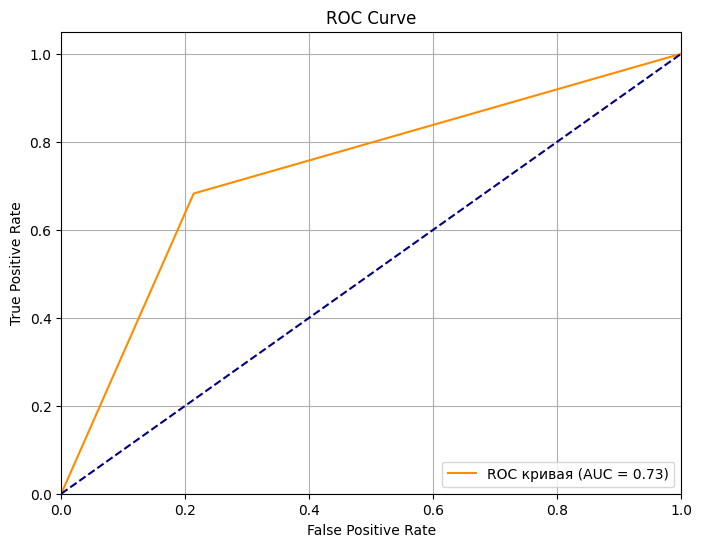

In [79]:
model_rf_opt.plot_roc_auc()

## Эксперимент SVM

In [82]:
# Создаем пайплайн для обучения с нормализацией
pipeline_svm = Pipeline([
                       ('scaler', preprocessing.MinMaxScaler()),
                       ('svc', svm.SVC(kernel='rbf', random_state=RANDOM_STATE))]
                       )

model_svm = TrainModel(X_train_ohe, X_valid_ohe, y_train_cut, y_valid, model=pipeline_svm)
svm_dict = model_svm.train_model()
svm_dict

{'Accuracy train': 0.64,
 'Accuracy valid': 0.73,
 'Precision train': 0.65,
 'Precision valid': 0.12,
 'Recall train': 0.52,
 'Recall valid': 0.54,
 'f1 score train': 0.58,
 'f1 score valid': 0.19,
 'ROC AUC score train': np.float64(0.64),
 'ROC AUC score valid': np.float64(0.64)}